<a href="https://colab.research.google.com/github/dbasso98/Svevo/blob/main/ml_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
spacy.cli.download("it_core_news_sm")
import it_core_news_sm
import seaborn as sns

## Analysis of Svevo’s letters corpus

A corpus of approximately 900 letters sent by and received to Italo Svevo, the famous writer from Trieste, is publicly available. The letters are written in different languages (Italian, English, German, and Triestino, the dialect of Trieste); sometimes, more than one language is used in the same letter.

The goal is to discover and report:

 - which are the main topics of discussion in the corpus, who are the persons which each topic is more associated with, how does the interest on different topics evolve over the time

- which are the sentiments (positive, negative, at least) expressed in the letters, how are they related with persons and topics, how do they evolve over the time
    
The corpus contains info about: corpus section name, index of letter in the section, date of the letter, year of the letter, sender of the letter, location of the sender, recipient, location of the recipient, languages used in the letter, main language, text of the letter. The corpus has already been preliminary analyzed.

In [ ]:
url = 'https://raw.githubusercontent.com/lykos273998/Svevo/main/carteggio_svevo3.csv'
data = pd.read_csv(url, sep=';')

Refine using only italian letters since they are much more than other ones (i.e. 862/894 letters)

In [ ]:
italian_df = data[data['mainLanguage'] == 'ITA']
italian_df.index = np.arange(0,italian_df.shape[0])

Let's clean up a little bit our dataframe. We want to keep punctuation because it could be relevant for sentiment detection. We will for first lowercase everything and remove stop words and do some stemming.

For tokenization I use spacy, https://spacy.io/models/it, here are shown syntax accurcay depending on operations we want to do.
Since spacy doesn't support stemming we will go with lemmatiazion, which is similar but slower in performances because it does not truncate each word to its morphological root but converts them to their first form variants. However lemmatization is good because it takes into account also POS in order to determine the lemma for one word. 

In [ ]:
# Lowercase letters
italian_df["text"] = italian_df["text"].str.lower()

# Tokenize, lemmatize and remove stop words
nlp = it_core_news_sm.load()
it_stop_words = []#stopwords.words('italian')
custom_stop_words = ['me','xe', 'el', 'lettera', 'schmitz','ettore', 'signora', 'signore', 'scrivere', 'sapere','fare', 'cosa','essere']
it_stop_words.extend(custom_stop_words)
token = italian_df
token['filtered'] = token.text.apply(lambda filter: 
                                      " ".join(token.lemma_ for token 
                                               in nlp(filter)
                                               if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'PUNCT']))


In [ ]:
# Loading R
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [ ]:
%%R
install.packages("syuzhet")

In [ ]:
%%R
library("dplyr")
library("syuzhet")

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
%%R -i token

resulting_sentiments <- data.frame(anger = numeric(), 
                                   anticipation = numeric(),
                                   disgust = numeric(),
                                   fear = numeric(), 
                                   joy = numeric(), 
                                   sadness = numeric(), 
                                   surprise = numeric(),
                                   trust = numeric(),
                                   negative = numeric(),
                                   positive = numeric())

for(row in 1:nrow(token)) {
  text <- token[row, 'filtered']
  sentences <- get_sentences(text)
  sentiment_df <- get_nrc_sentiment(sentences, lang = "italian")
  single_text <- data.frame(t(colSums(sentiment_df)))
  resulting_sentiments <- rbind(resulting_sentiments, single_text)
}


In [ ]:
sentiments = %R resulting_sentiments

In [ ]:
sentiments

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1,10.0,15.0,5.0,8.0,12.0,4.0,3.0,19.0,17.0,32.0
2,1.0,5.0,1.0,2.0,3.0,4.0,1.0,4.0,6.0,10.0
3,1.0,2.0,1.0,2.0,5.0,1.0,1.0,4.0,1.0,10.0
4,0.0,0.0,0.0,0.0,3.0,0.0,1.0,4.0,0.0,6.0
5,2.0,8.0,2.0,3.0,7.0,10.0,6.0,12.0,8.0,17.0
...,...,...,...,...,...,...,...,...,...,...
822,0.0,5.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,6.0
823,0.0,4.0,1.0,0.0,7.0,2.0,1.0,4.0,5.0,12.0
824,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0
825,3.0,8.0,3.0,2.0,8.0,0.0,3.0,10.0,10.0,19.0


Now that we have positive, negative sentiment and all different emotions we can compute percentage of each sentiment inside all letters, connect specific sentiment to specific person and how sentiments change considering lifetime

In [ ]:
#sentiments_clean.reset_index(drop=True, inplace=True)
sentiments.reset_index(drop=True, inplace=True)

In [ ]:
#full_df = italian_df.join(sentiments_clean, how='outer')
full_filtered_df = token.join(sentiments, how='outer')

Now that we have merged original dataframes with emotions/sentiments associated to each letter, we can make some plots.

In [ ]:
neg_and_pos = full_filtered_df['positive'].sum()+full_filtered_df['negative'].sum()
emotions = full_filtered_df['anger'].sum()+full_filtered_df['anticipation'].sum() \
         + full_filtered_df['disgust'].sum()+full_filtered_df['fear'].sum() \
         + full_filtered_df['joy'].sum()+full_filtered_df['sadness'].sum() \
         + full_filtered_df['surprise'].sum()+full_filtered_df['trust'].sum() 

pos_percent = full_filtered_df['positive'].sum()/neg_and_pos
neg_percent = full_filtered_df['negative'].sum()/neg_and_pos
anger_percent = full_filtered_df['anger'].sum()/emotions
anticipation_percent = full_filtered_df['anticipation'].sum()/emotions
disgust_percent = full_filtered_df['disgust'].sum()/emotions
fear_percent = full_filtered_df['fear'].sum()/emotions
joy_percent = full_filtered_df['joy'].sum()/emotions
sadness_percent = full_filtered_df['sadness'].sum()/emotions
surprise_percent = full_filtered_df['surprise'].sum()/emotions
trust_percent = full_filtered_df['trust'].sum()/emotions

sentiment_values = [neg_percent, pos_percent]
emotion_values = [anger_percent, anticipation_percent, disgust_percent, fear_percent, joy_percent, sadness_percent, surprise_percent, trust_percent]

So here below we have barplots for sentiments and emotions taking into account the entire corpus of letters

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


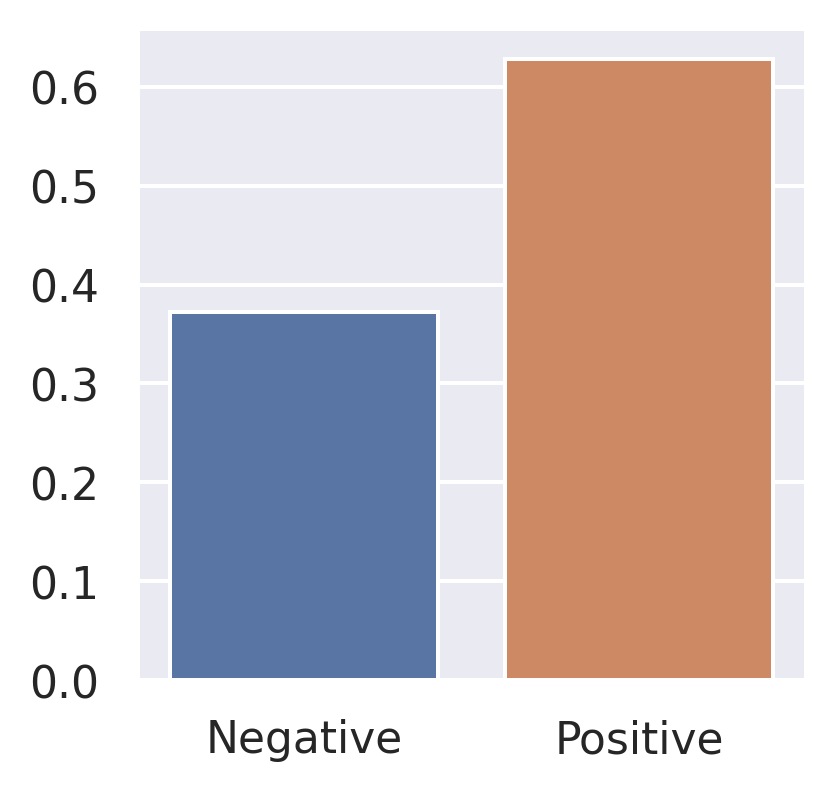

In [ ]:
plt.rcParams["figure.dpi"] = 144

sns.set_theme(style="darkgrid")
sns.color_palette("pastel")
np_label = ['Negative', 'Positive'] 
plt.figure(figsize=(3,3))
sns.barplot(np_label, sentiment_values)

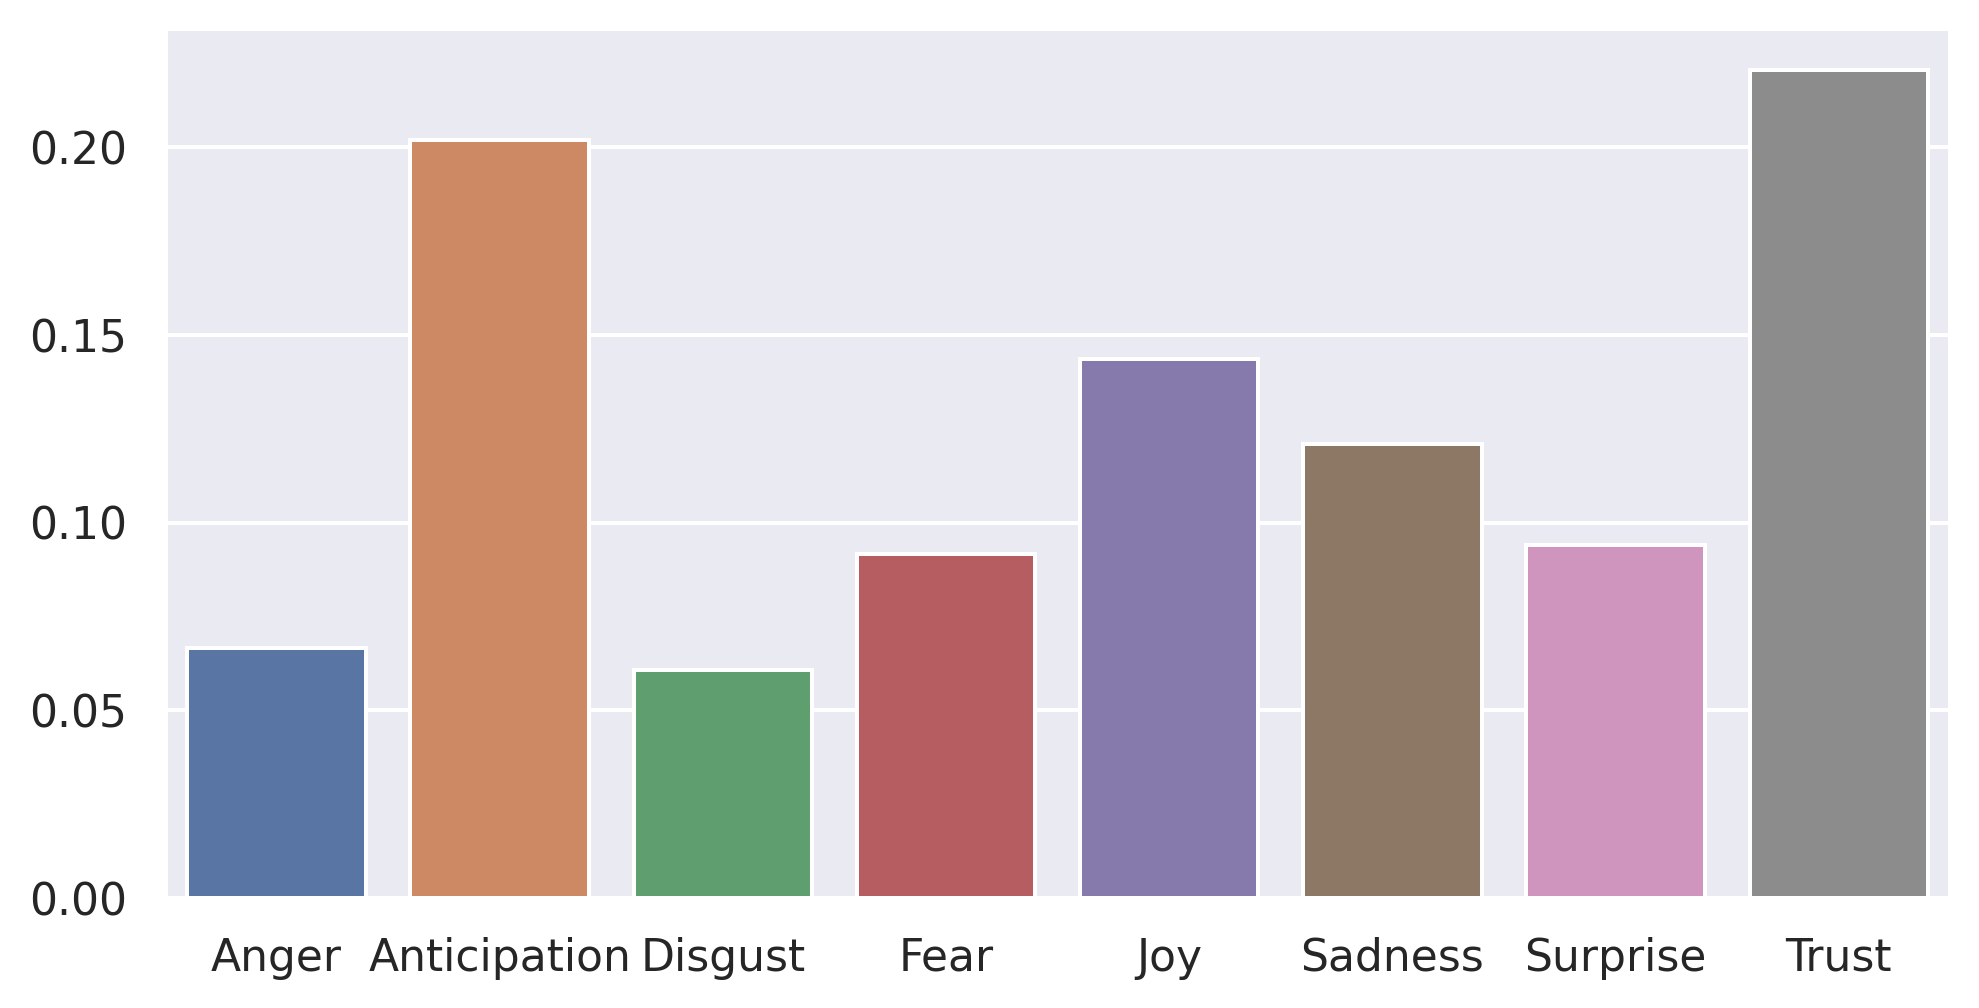

In [ ]:
emo_label = ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy','Sadness','Surprise','Trust']
plt.figure(figsize=(8,4))
sns.barplot(x = emo_label, y = emotion_values)

Now we can group by corpus, so we can better understand sentiments related to one specific person

In [ ]:
# first take a look at which are the most important people for Svevo while 
# exchanging letters, we will consider top 1
top_10 = italian_df['corpus'].value_counts().index.tolist() 
top_10 = top_10[:10]
top_10

['Schmitz Livia',
 'Svevo Montale',
 'Schmitz Henri Michel',
 'Svevo Jahier',
 'Svevo Comnène',
 'Schmitz Joyce',
 'Schmitz Prezzolini',
 'Svevo Larbaud',
 'Schmitz Pasini',
 'Svevo Crémieux']

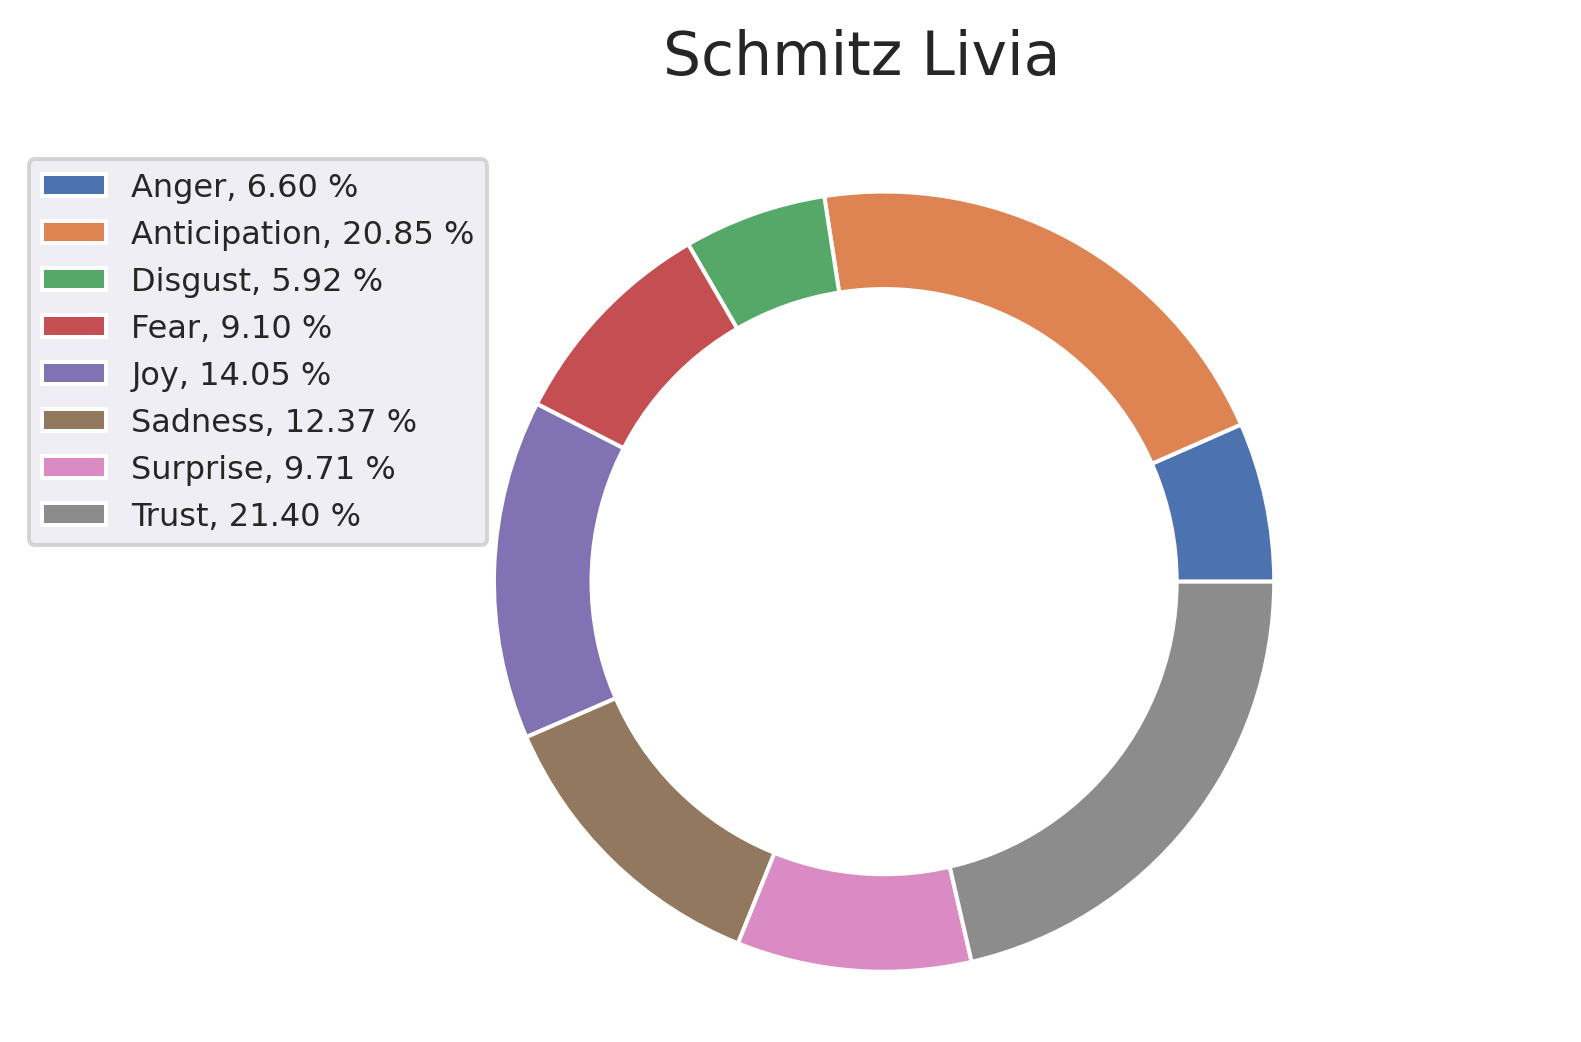

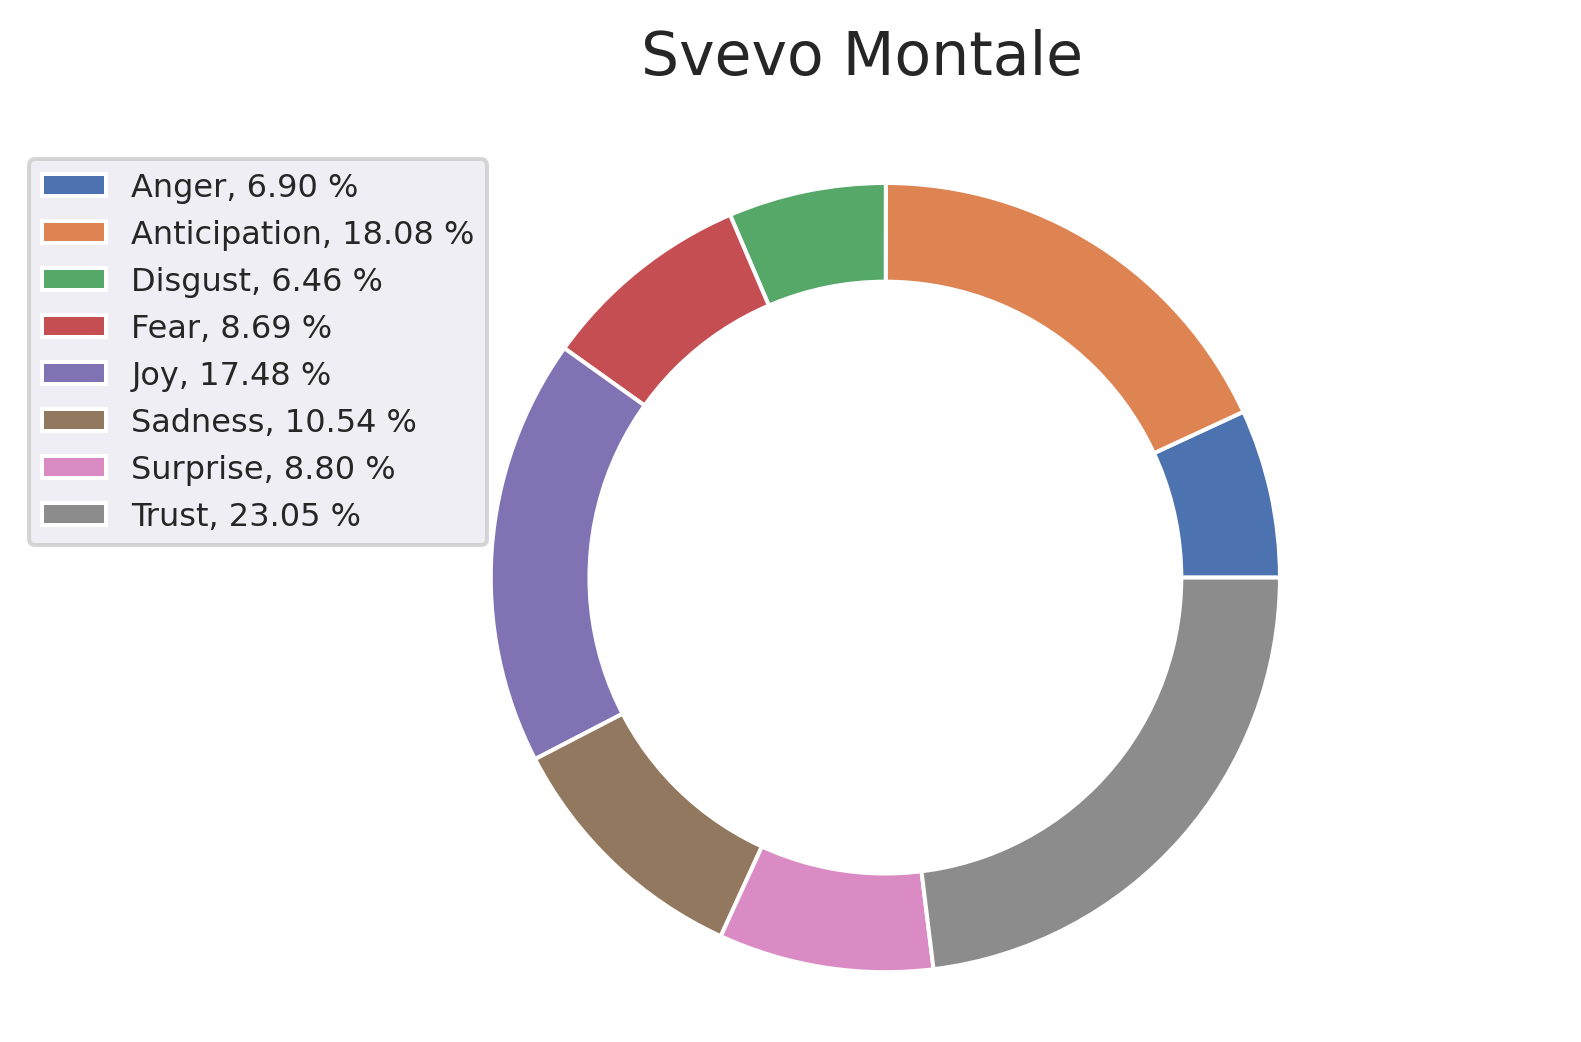

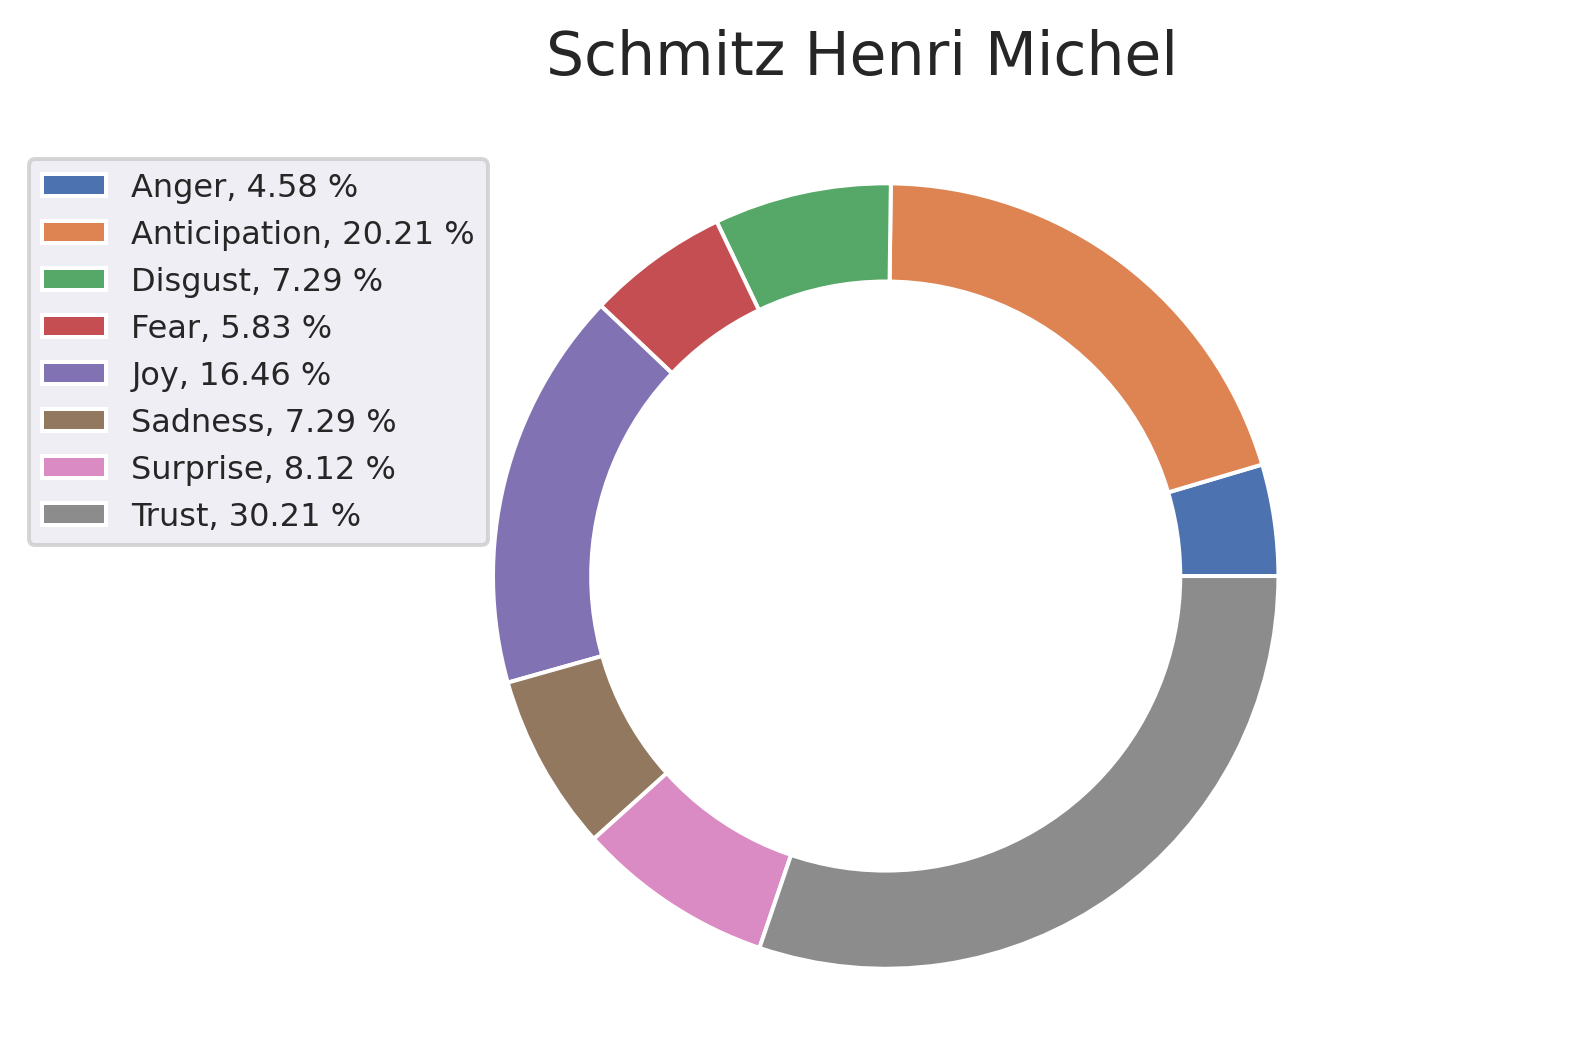

In [ ]:
corpus_df = full_filtered_df.groupby('corpus', as_index=False).mean()
corpus_df.drop(['n','index','year'], axis = 1, inplace = True)

for person in top_10[0:3] :
  person_emotion = corpus_df[corpus_df['corpus']==person].iloc[:,1:9]
  person_emotion = person_emotion.values/person_emotion.values.sum()
  person_emotion = person_emotion[0] * 100
  fig = plt.figure()
  fig.suptitle(person, fontsize = 15)
  plt.pie(person_emotion, explode=None)
  plt.legend(labels = ['%s, %1.2f %%' % (l, s) for l, s in zip(emo_label, person_emotion)],
             loc='upper left', bbox_to_anchor=(-0.15, 1),
             fontsize=8)
  centre_circle = plt.Circle((0,0),0.75,color='white', fc='white',linewidth=1)
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)

  plt.axis('equal')

plt.show()

Now plot sentiment related to each person

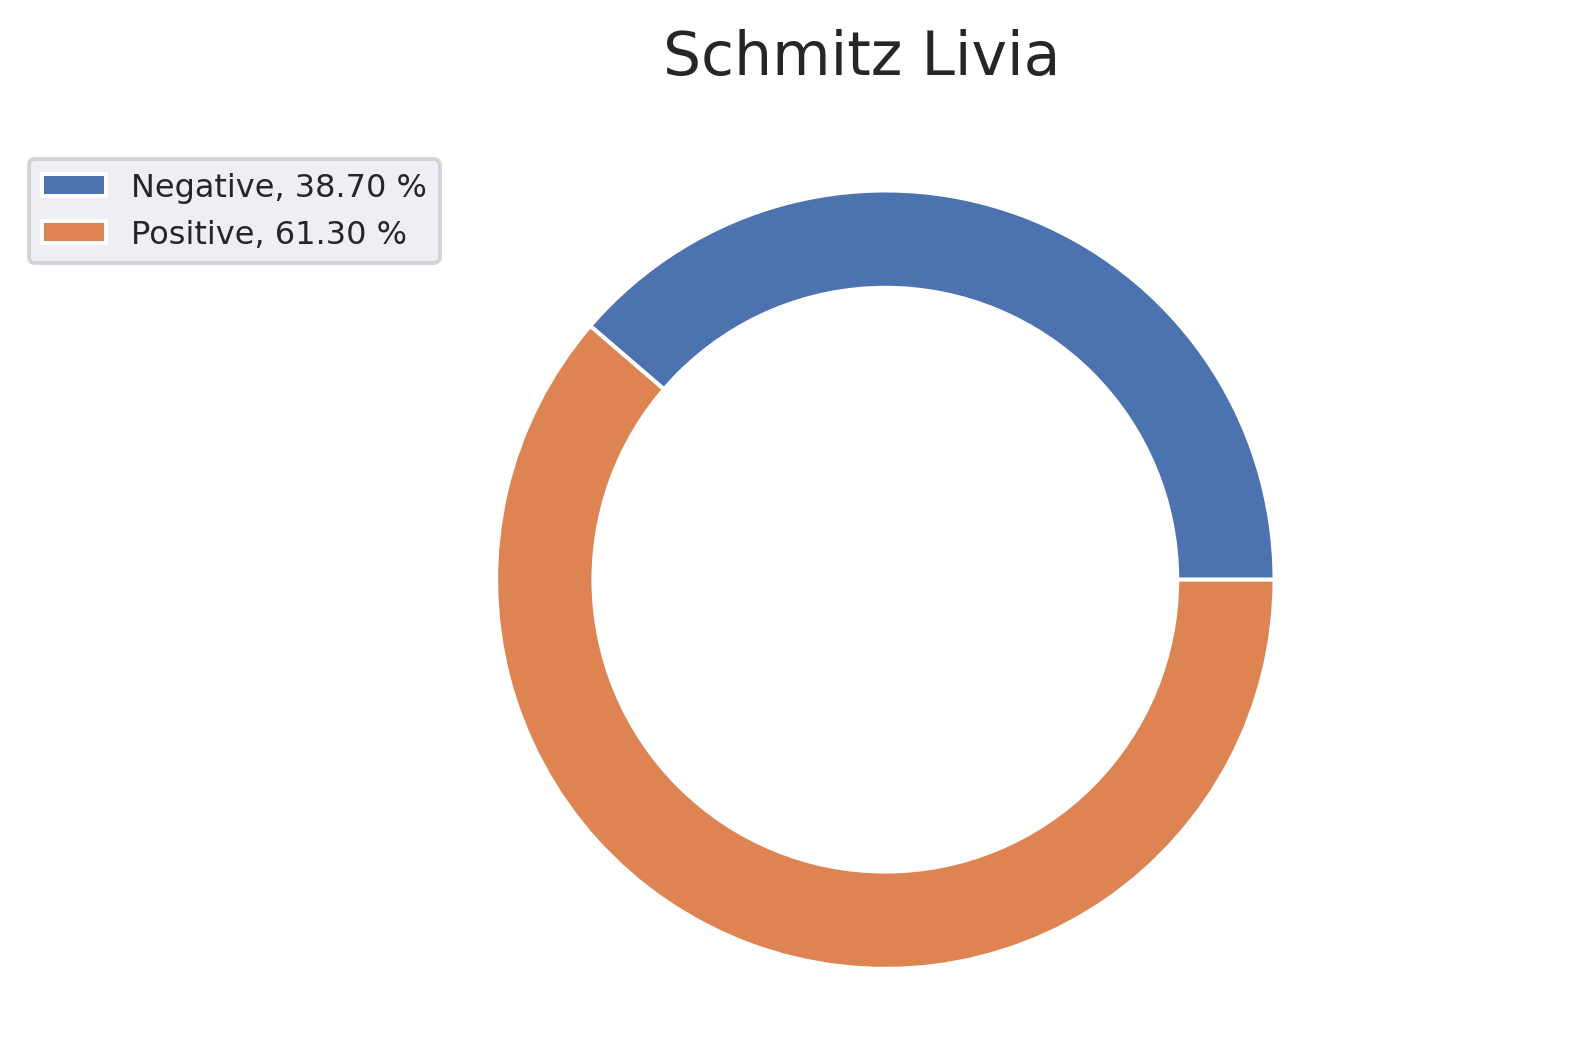

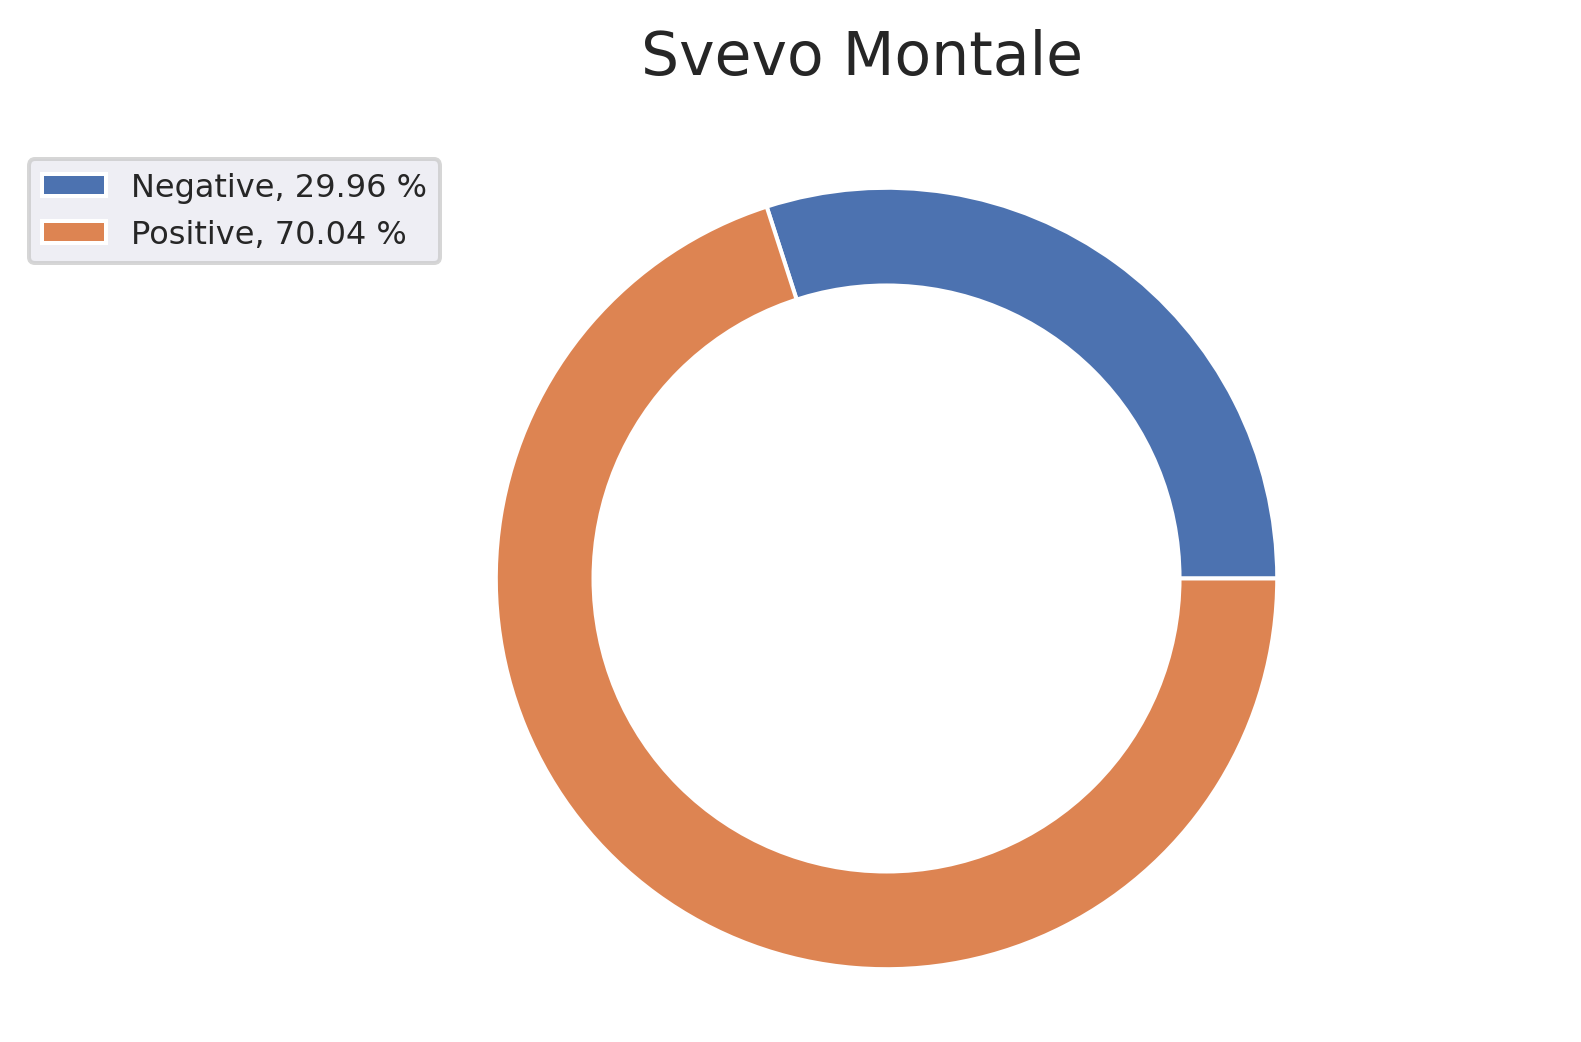

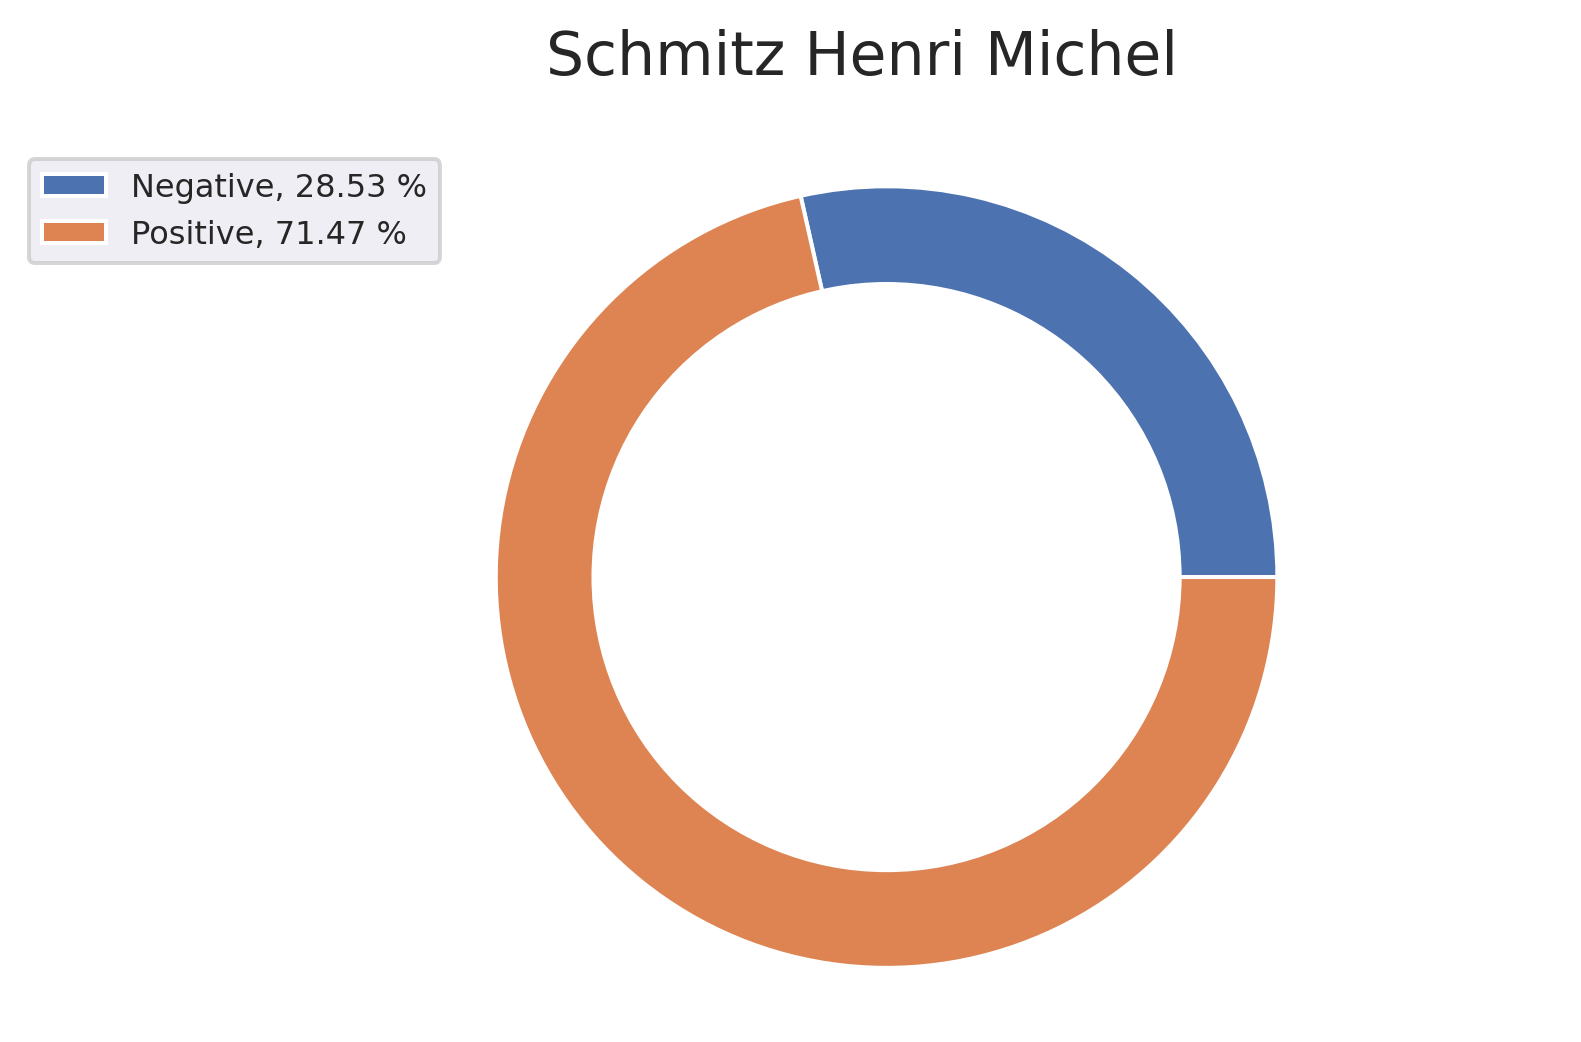

In [ ]:
for person in top_10[0:3] :
  person_sentiment = corpus_df[corpus_df['corpus']==person].iloc[:,9:11]
  person_sentiment = person_sentiment.values/person_sentiment.values.sum()
  person_sentiment = person_sentiment[0] * 100
  fig = plt.figure()
  fig.suptitle(person, fontsize = 15)
  plt.pie(person_sentiment, explode=None)
  plt.legend(labels = ['%s, %1.2f %%' % (l, s) for l, s in zip(np_label, person_sentiment)],
             loc='upper left', bbox_to_anchor=(-0.15, 1),
             fontsize=8)
  centre_circle = plt.Circle((0,0),0.75,color='white', fc='white',linewidth=1)
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)

  plt.axis('equal')

plt.show()

Now let's see how sentiment and emotions evolve during the years


In [ ]:
years_df = full_filtered_df.groupby('year', as_index=False).mean()
years_df.drop(['n','index'], axis = 1, inplace = True)

In [ ]:
for i in range(0,33):
  years_df.iloc[i,1:9] = years_df.iloc[i,1:9]/years_df.iloc[i,1:9].sum()
  years_df.iloc[i,9:11] = years_df.iloc[i,9:11]/years_df.iloc[i,9:11].sum()

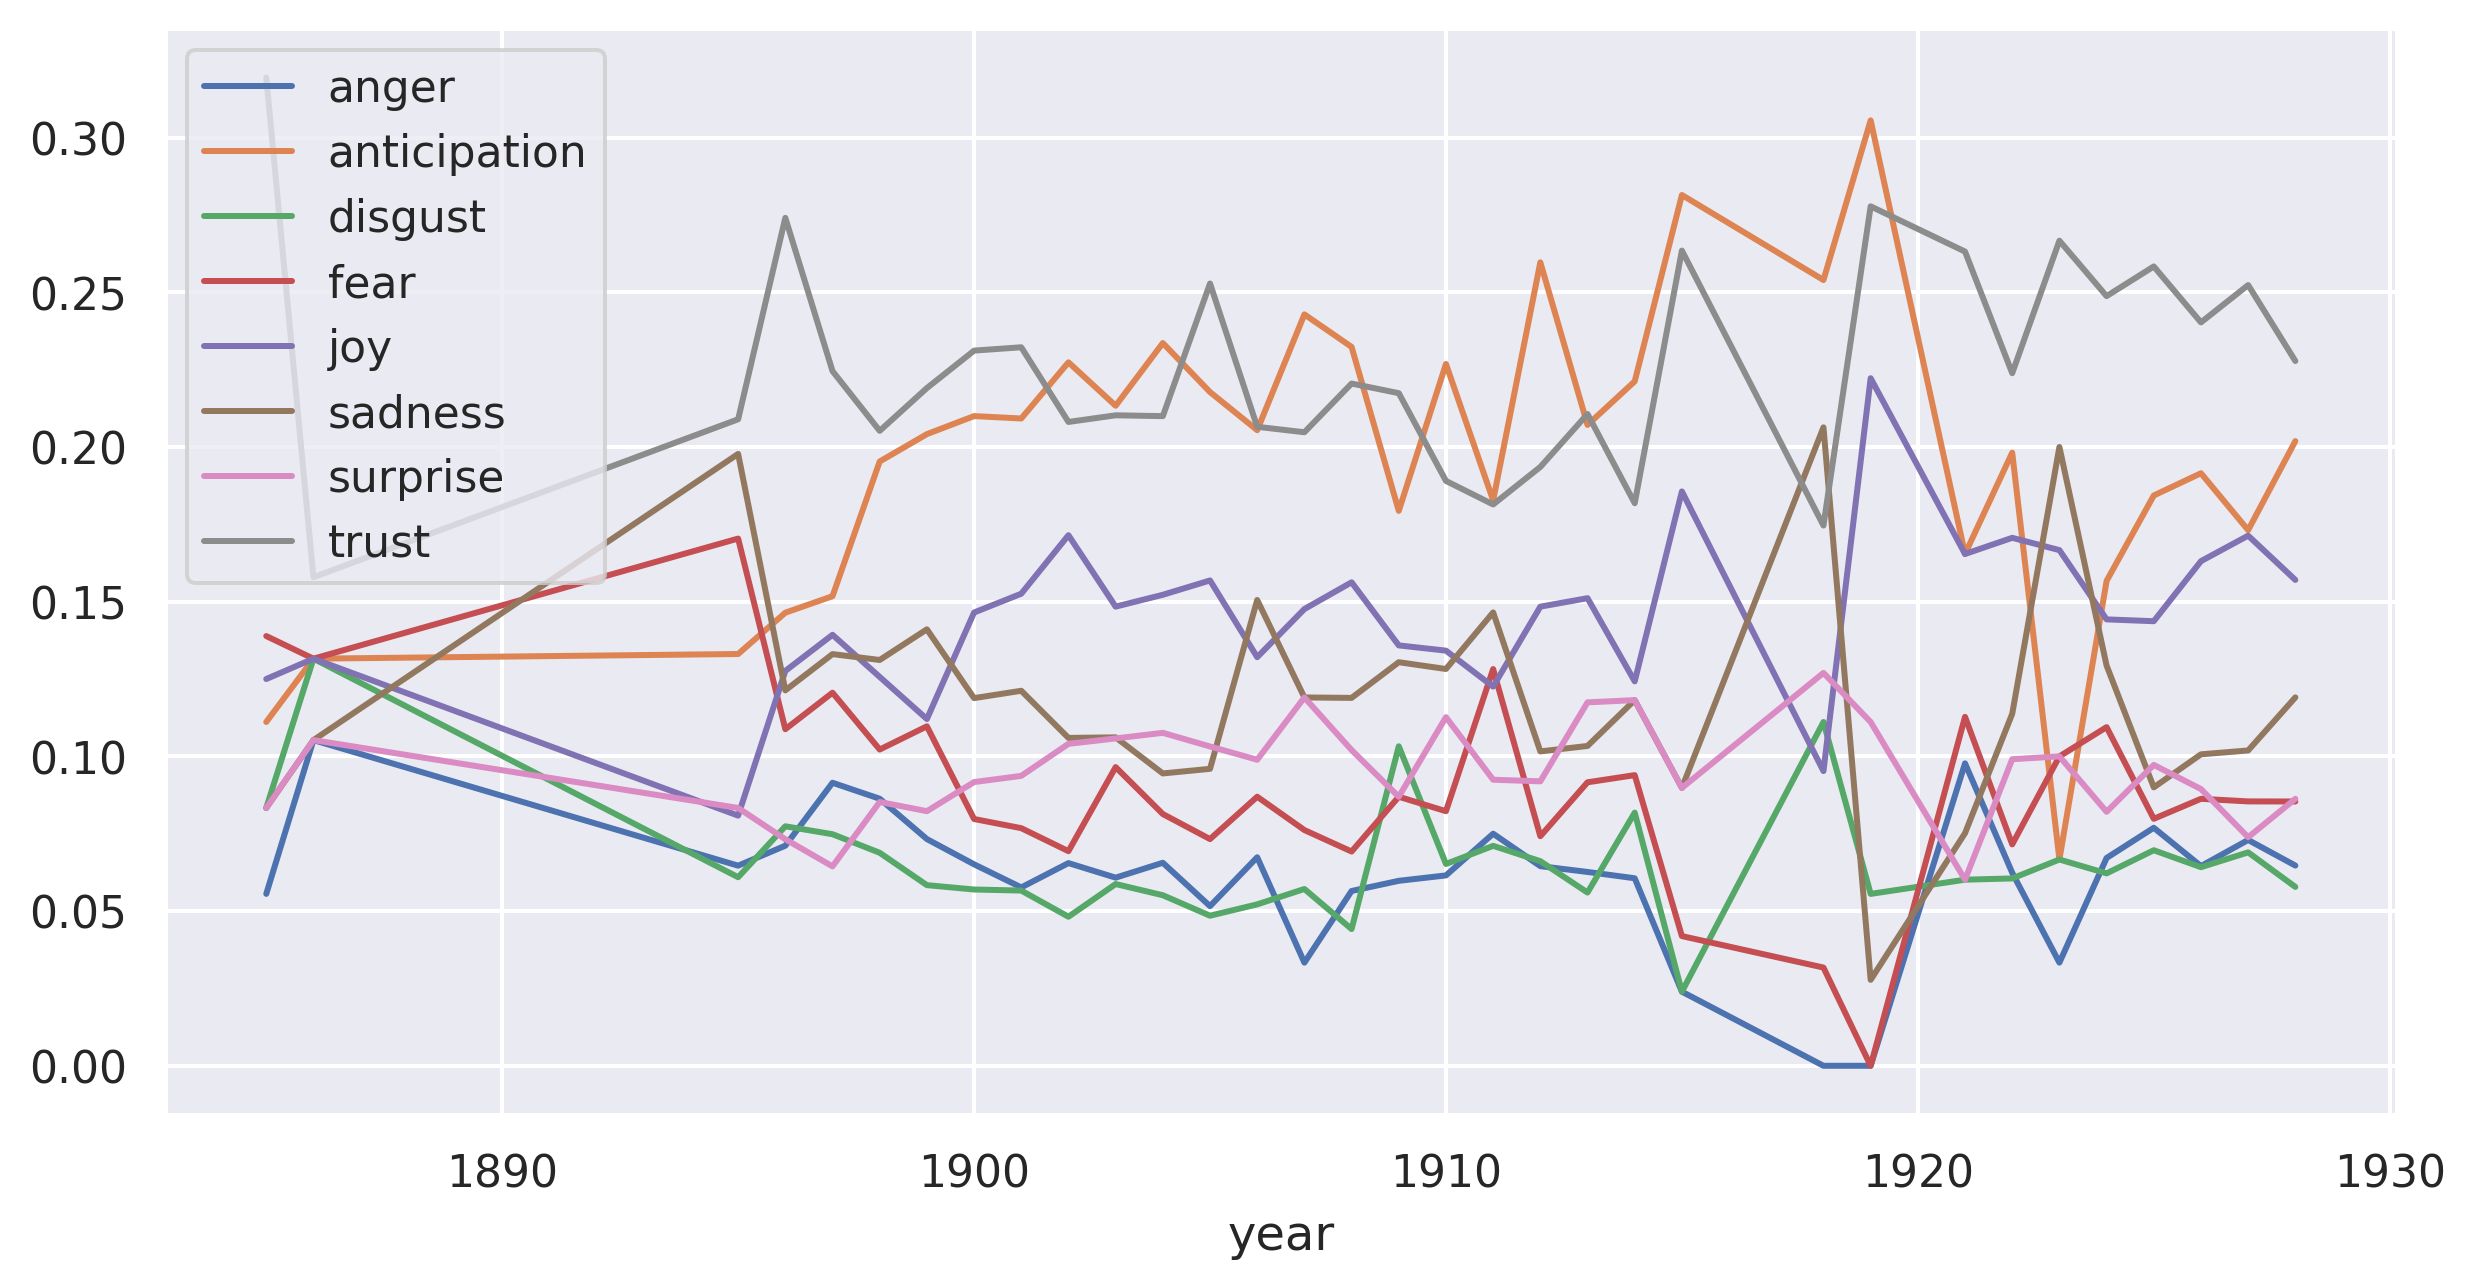

In [ ]:
years_df.plot(x = 'year', y = ['anger', 'anticipation', 'disgust', 'fear', 'joy'
                              ,'sadness','surprise','trust'], figsize = (10,5))

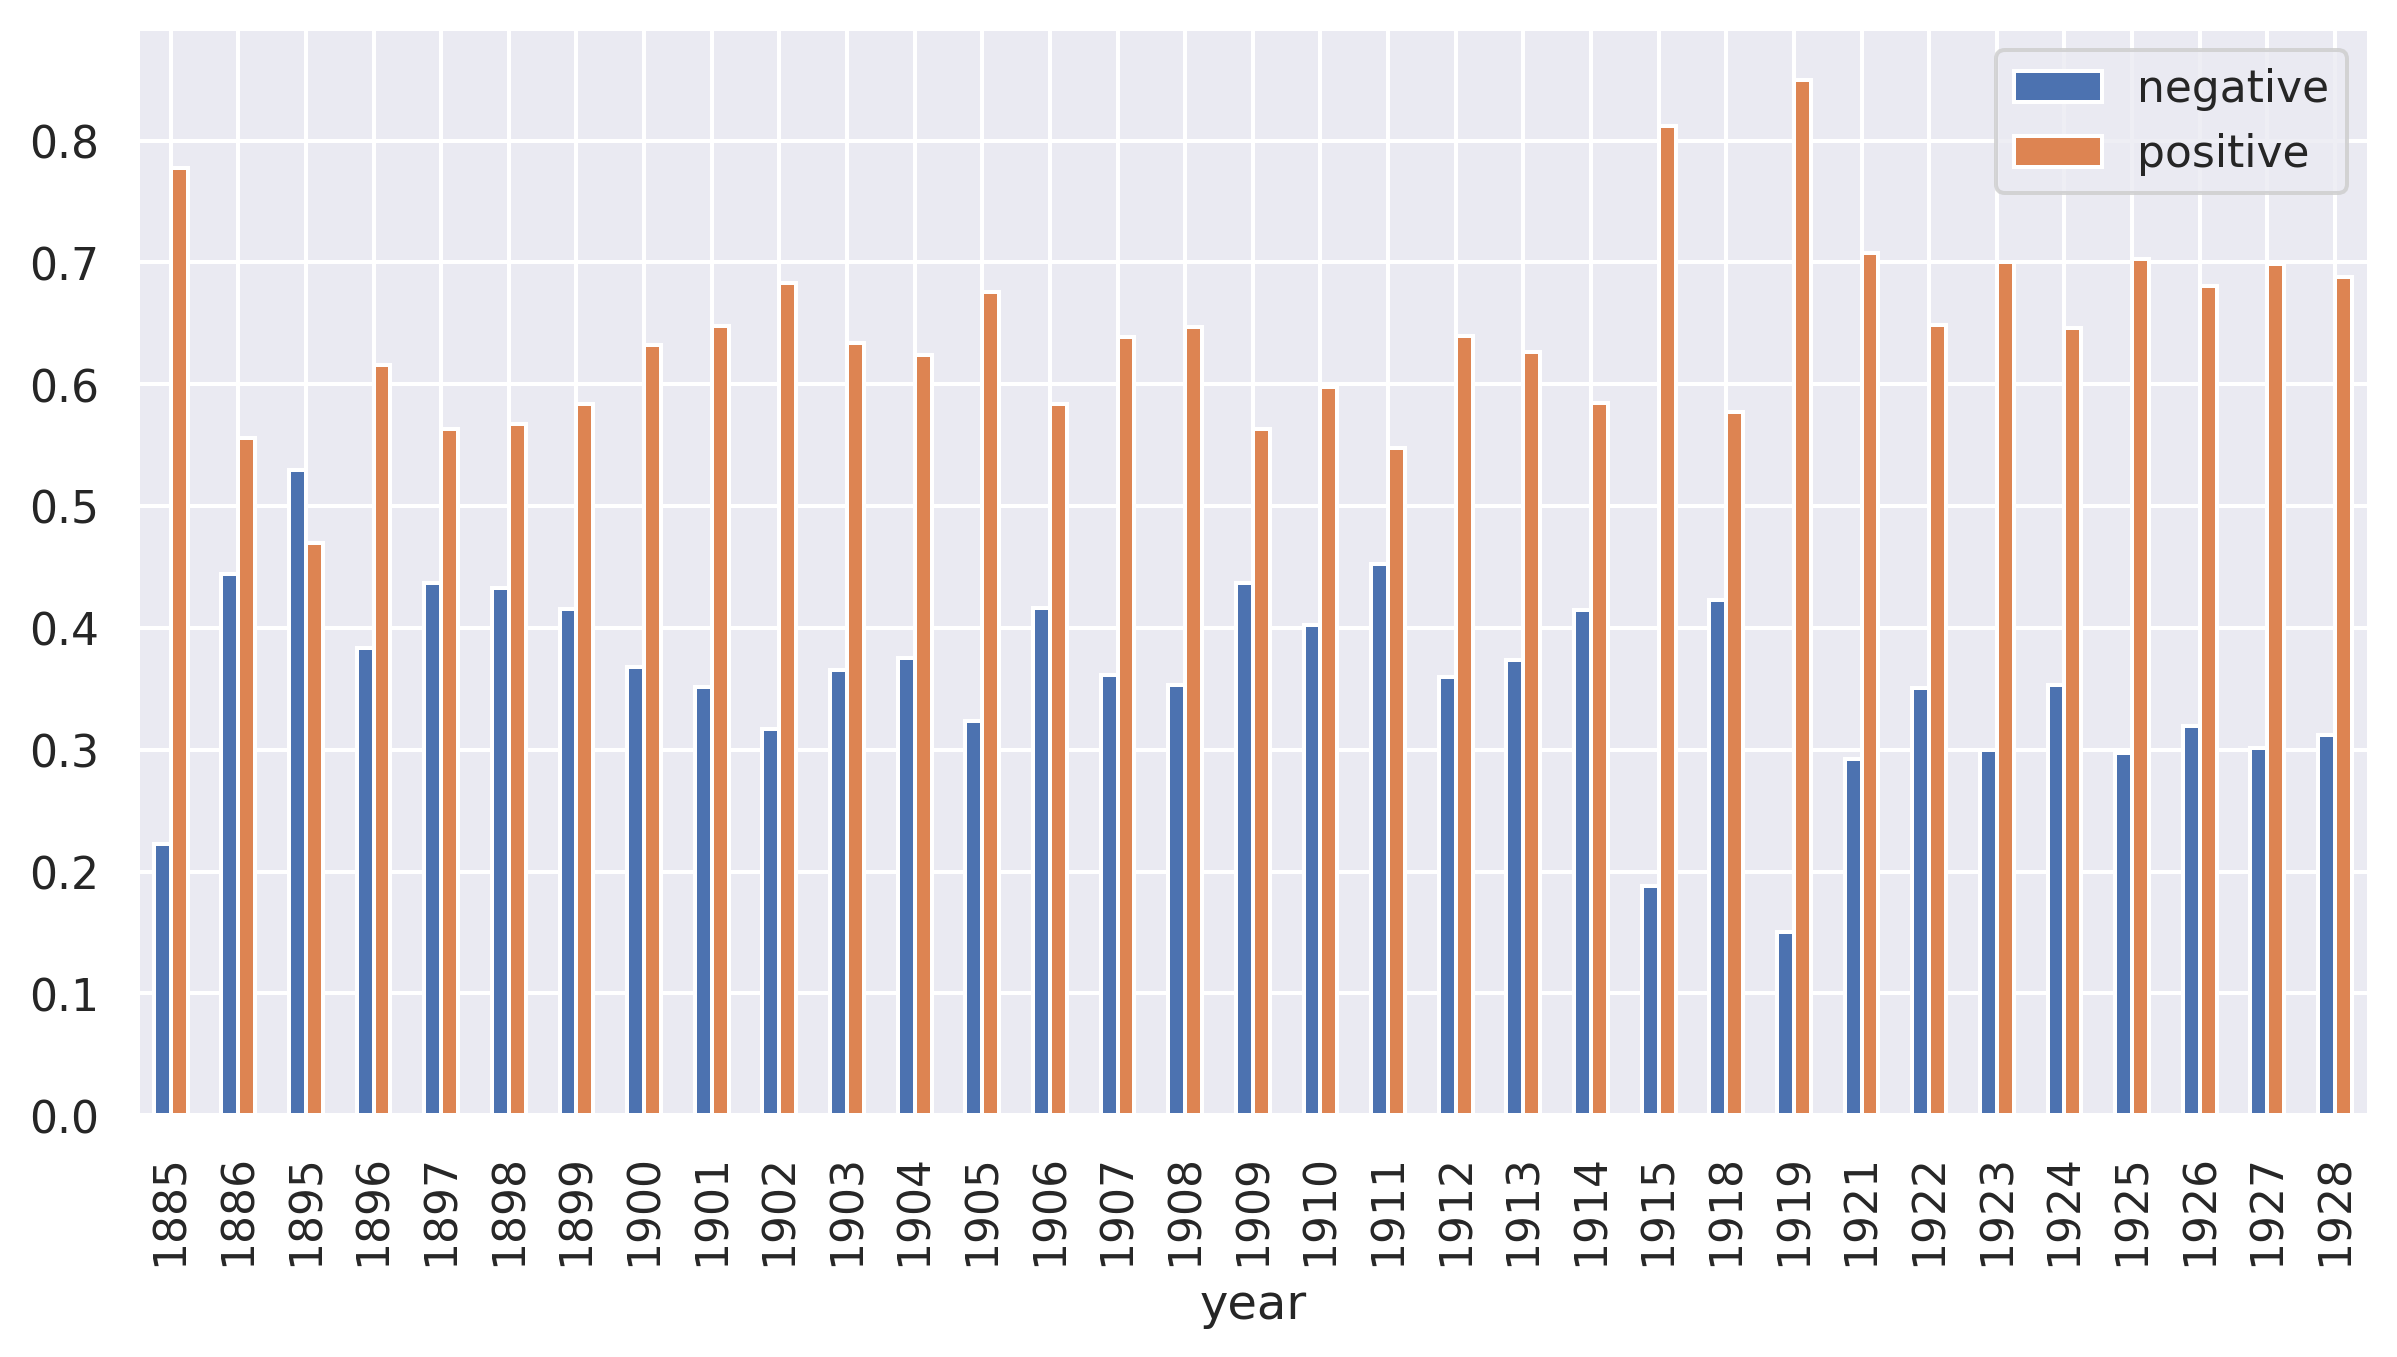

In [ ]:
years_df.plot.bar(x = 'year', y = ['negative', 'positive'], figsize = (10,5))

In [ ]:
sum(italian_df['year']==1928)


35